# Supervised Machine Learning Model Interpretation

This training module was developed by Alexis Payton, MS and Dr. Julia E. Rager

Fall 2023

WORDS.

# Decision Boundaries

## Decision Boundary Plot
They do not always have to be the predictors with the highest variable importance. Sometimes predictors are selected based upon the implications relevant to the research question. For example in [Perryman et. al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0285721), lung response resulting from ozone exposure was investigated by sampling derivatives of cholesterol biosynthesis in human subjects. In this paper, these sterol metabolites were used to predict whether a subject would be classified as having a lung response that was considered to be non-responsive or a responsive. A decision boundary plot was made using two predictors:

+ Cholesterol, given that it had the highest variable importance and
+ Vitamin D, given its synthesis can be affected by ozone despite it having a lower variable importance in the paper's models.

<img src="Images/Image1.png" width="684" />

Takeaways from this decision boundary plot:
+ Subjects with more lung inflammation ("responders") after ozone exposure tended to have higher Vitamin D levels and lower Cholesterol levels.
+ Thse "responder" subjects were more likely to be non-asthmatics. 

## Introduction to Training Module
In this activity, we will analyze an example dataset to see whether we can use environmental monitoring information to predict areas of contamination through random forest modeling. Specifically, RF will leverage a dataset of well water variables that span geospatial location, sampling date, and well water attributes, with the goal of predicting whether detectable levels of inorganic arsenic (iAs) are present. This dataset was obtained through the sampling of 713 private wells across North Carolina using a method that was capable of detecting levels of iAs. After the algorithm has been trained and tested, model performance is assessed using the aforementioned confusion matrix metrics.
TALK ABOUT HOW THIS WAS DESCRIBED PREVIOUSLY

## Training Module's Environmental Health Questions

This training module was specifically developed to answer the following environmental health questions:

1.???

## Script Preparations

### Cleaning the global environment

In [ ]:
rm(list=ls())

### Installing required R packages
If you already have these packages installed, you can skip this step, or you can run the below code which checks installation status for you

In [3]:
if (!requireNamespace("readxl"))
  install.packages("readxl");
if (!requireNamespace("lubridate"))
  install.packages("lubridate");
if (!requireNamespace("tidyverse"))
  install.packages("tidyverse");
if (!requireNamespace("caret"))
  install.packages("caret");
if (!requireNamespace("randomForest"))
  install.packages("randomForest");

Loading required namespace: caret

Loading required namespace: randomForest



### Loading R packages required for this session

In [1]:
library(readxl);
library(lubridate);
library(tidyverse);
library(caret);
library(randomForest);


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.3     ✔ readr   2.1.4
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.3     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




### Set your working directory

In [ ]:
setwd("/filepath to where your input files are")

### Importing example dataset
**Will need to change input to module number and add module number to the file itself**

In [2]:
# Load the data
arsenic_data <- data.frame(read_excel("Module5/Module5_Arsenic_Data.xlsx"))

# View the top of the dataset
head(arsenic_data) 

,Tax_ID,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Detect_Concentration
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,1006004,9/24/12,52,165,41,60.0,7.7,ND
2,1024009,12/17/15,40,445,42,2.0,7.3,ND
3,1054019,2/2/15,45,160,40,40.0,7.4,ND
4,1057017,10/22/12,42,440,57,1.5,8.0,D
5,1060006,1/3/11,48,120,42,25.0,7.1,ND
6,1066006,12/15/15,60,280,32,10.0,8.2,D


### Changing Data Types 
First, `Detect_Concentration` needs to be converted from a character to a factor, so that Random Forest to know that non-detect (binarized as 0) data is considered baseline. `Water_Sample_Date` needs to be converted from a character to a date type, so that Random Forest understands this column contains dates.

In [3]:
arsenic_data = arsenic_data %>%
    # Converting `Detect_Concentration` from a character to a factor
    mutate(Detect_Concentration = relevel(factor(ifelse(Detect_Concentration == "D", 1, 0)), ref = "0"),
        # converting water sample date from a character to a date type 
        Water_Sample_Date = mdy(Water_Sample_Date)) %>%
        # Removing tax id and only keeping the predictor and outcome variables in the dataset
        select(-Tax_ID)

head(arsenic_data)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Detect_Concentration
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2012-09-24,52,165,41,60.0,7.7,0
2,2015-12-17,40,445,42,2.0,7.3,0
3,2015-02-02,45,160,40,40.0,7.4,0
4,2012-10-22,42,440,57,1.5,8.0,1
5,2011-01-03,48,120,42,25.0,7.1,0
6,2015-12-15,60,280,32,10.0,8.2,1


## Setting up Cross Validation

In [4]:
# Setting seed for reproducibility
set.seed(12)

# 5-fold cross validation
arsenic_index = createFolds(arsenic_data$Detect_Concentration, k = 5) 

# Creating vectors for parameters to be tuned
ntree_values = c(50, 250, 500) # number of trees 
p = dim(arsenic_data)[2] - 1 # number of predictor variables in the dataset
mtry_values = c(sqrt(p), p/2, p) # number of predictors to be used in the model

## Predicting iAs Detection with a Random Forest (RF) Model

In [5]:
# Setting the seed again so the predictions are consistent
set.seed(12)

# Creating an empty dataframe to save the variable importance
variable_importance_df = data.frame()

# Iterating through the cross validation folds
for (i in 1:length(arsenic_index)){
    # Training data
    data_train = arsenic_data[-arsenic_index[[i]],]
    
    # Test data
    data_test = arsenic_data[arsenic_index[[i]],]
    
    # Creating empty lists and dataframes to store errors 
    reg_rf_pred_tune = list()
    rf_OOB_errors = list()
    rf_error_df = data.frame()
    
    # Tuning parameters: using ntree and mtry values to determine which combination yields the smallest OOB error 
    # from the validation datasets
    for (j in 1:length(ntree_values)){
        for (k in 1:length(mtry_values)){
            
            # Running RF to tune parameters
            reg_rf_pred_tune[[k]] = randomForest(Detect_Concentration ~ ., data = data_train, 
                                                 ntree = ntree_values[j], mtry = mtry_values[k])
            # Obtaining the OOB error
            rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                   "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
            
            # Storing the values in a dataframe
            rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
        }
    }
    
    # Finding the lowest OOB error using best number of predictors at split
    best_oob_errors <- which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

    # Now running RF on the entire training set with the tuned parameters
    reg_rf <- randomForest(Detect_Concentration ~ ., data = data_train,
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)],
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

    # Predicting on test set and adding the predicted values as an additional column to the test data
    data_test$Pred_Detect_Concentration = predict(reg_rf, newdata = data_test, type = "response")

    # extracting variable importance
    variable_importanceortance_values = data.frame(importance(reg_rf)) %>%
        rownames_to_column(var = "Predictor")
    variable_importance_df = rbind(variable_importance_df, variable_importanceortance_values)
}

# Taking average
variable_importance_df = variable_importance_df %>%
    group_by(Predictor) %>%
    summarise(MeanDecreaseGini = mean(MeanDecreaseGini)) %>%
    # sorting by most important variables
    arrange(-MeanDecreaseGini)

# Viewing the model's variable importance
variable_importance_df

Predictor,MeanDecreaseGini
<chr>,<dbl>
Casing_Depth,51.50761
pH,42.70690
Water_Sample_Date,37.45238
Flow_Rate,33.33481
Well_Depth,32.41073
Static_Water_Depth,30.39985


### Modifying dataframe here for plotting 
Transforming the dataframe so that figure is more legible. Specifically, spaces will be added between the variables and the `Predictor` column will be put into a factor to rearrange the order of the variables from lowest to highest mean decrease gini. For additional information on improving visualization see [Module 3.4](INSERT LINK).

In [6]:
# Adding spaces between the variables
modified_variable_importance_df = variable_importance_df %>%
     mutate(Predictor = ifelse(Predictor == "Casing_Depth", "Casing Depth",
                ifelse(Predictor == "Water_Sample_Date", "Water Sample Date",
                    ifelse(Predictor == "Flow_Rate", "Flow Rate",
                        ifelse(Predictor == "Well_Depth", "Well Depth",
                            ifelse(Predictor == "Static_Water_Depth", "Static Water Depth", 
                                   ifelse(Predictor == "pH", "pH", 
                                          NA)))))))

# Saving the order of the variables from lowest to highest mean decrease gini by putting into a factor
predictor_order = rev(modified_variable_importance_df$Predictor)
modified_variable_importance_df$Predictor = factor(modified_variable_importance_df$Predictor, levels = predictor_order)

head(modified_variable_importance_df)

Predictor,MeanDecreaseGini
<fct>,<dbl>
Casing Depth,51.50761
pH,42.70690
Water Sample Date,37.45238
Flow Rate,33.33481
Well Depth,32.41073
Static Water Depth,30.39985


## Variable Importance Plot

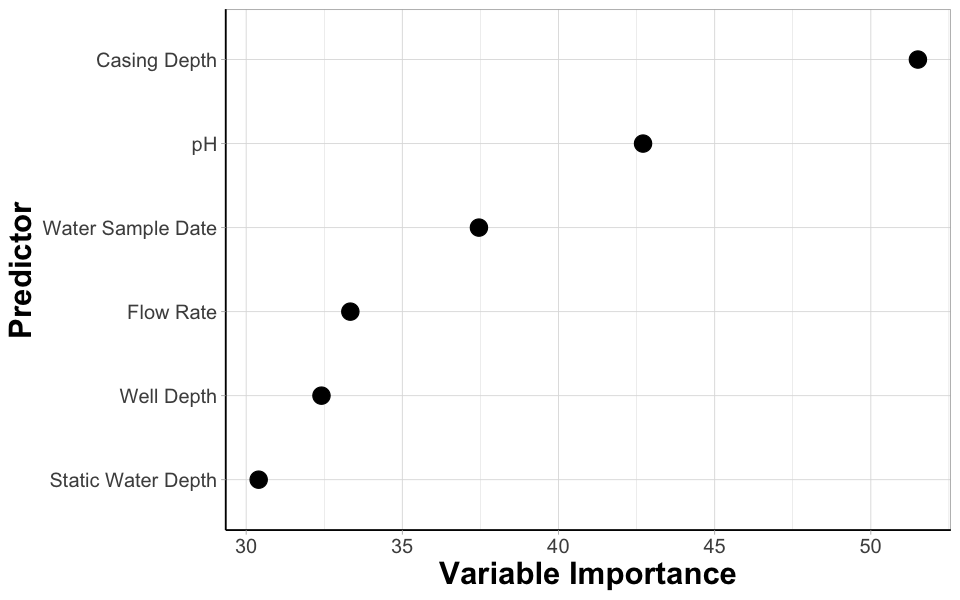

In [7]:
options(repr.plot.width=8, repr.plot.height=5) #changing plot size

ggplot(data = modified_variable_importance_df , 
             aes(x = MeanDecreaseGini, y = Predictor, size = 3)) + 
  geom_point() + 

  theme_light() + 
  theme(axis.line = element_line(color = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Variable Importance', y = 'Predictor') + #changing axis labels 
  
  guides(size = "none")#removing size legend

By rearranging the y axis from highest to lowest variable importance, it is easier to see that casing depth had the greatest impact on RF while static water depth had the least.

Since casing depth and pH have been identified as the predictors with the highest variable importance, they will be used as the two predictors for the decision boundary plot.

### Decision Boundary Calculation
Starting by training a RF model with casing depth and pH.

In [8]:
# Creating a dataframe with variables based on the highest predictors
highest_predictivity_data = data.frame(arsenic_data[,c("Casing_Depth", "pH", "Detect_Concentration")])

# Training RF
rf_detect_arsenic = randomForest(Detect_Concentration~., data = highest_predictivity_data)

In [9]:
# obtaining grid values and predictions visualize using ggplot
get_grid_df <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  # plotting original data
  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  # make grid (between min and max for each variable)
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)
    
  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  g$Pred_Class = p
    
  return(g)
}

# calling function
grid_df_rf = get_grid_df(rf_detect_arsenic, highest_predictivity_data, class = "Detect_Concentration")
head(grid_df_rf)

,Casing_Depth,pH,Pred_Class
,<dbl>,<dbl>,<fct>
1,27,5.400000,0
2,27,5.433333,0
3,27,5.466667,0
4,27,5.500000,0
5,27,5.533333,0
6,27,5.566667,0


## Decision Boundary Plot

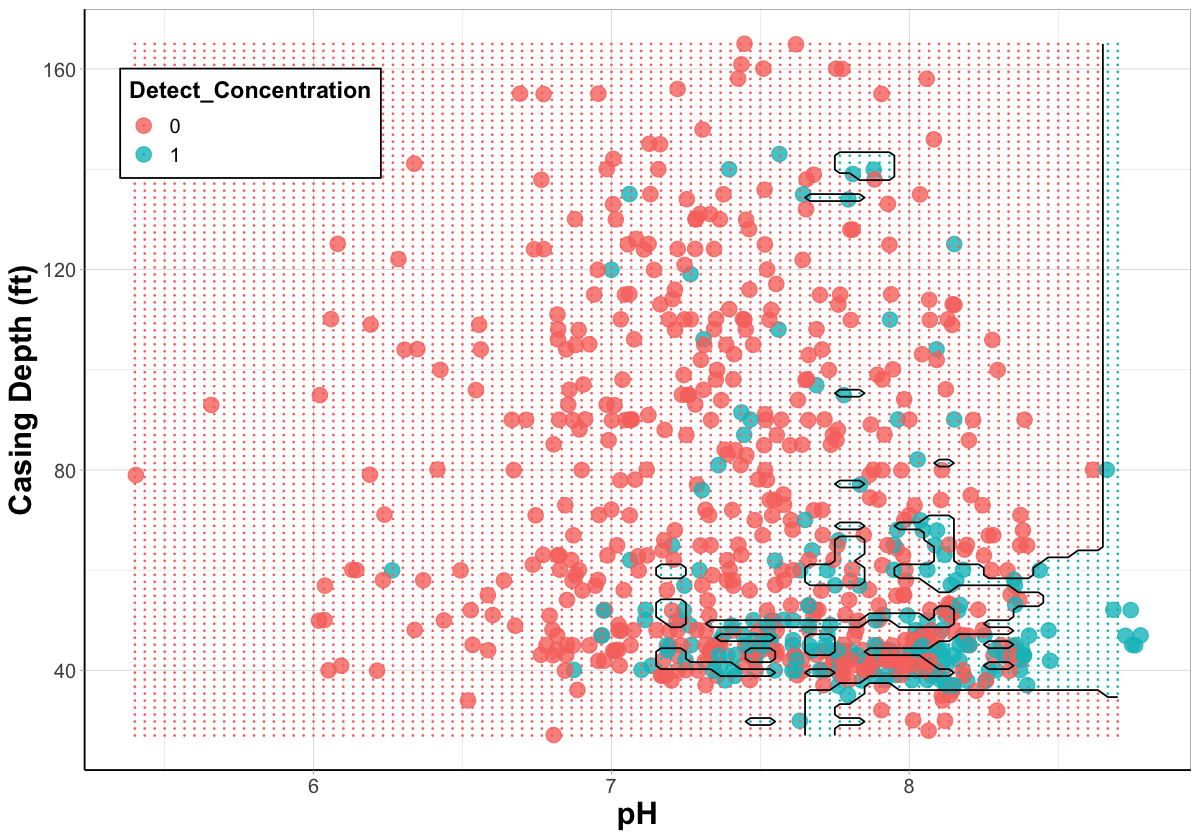

In [10]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

ggplot() +
  geom_point(data = arsenic_data, aes(x = pH, y = Casing_Depth, color = Detect_Concentration),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_rf, aes(x = pH, y = Casing_Depth, z = as.numeric(Pred_Class == "1")), 
               color = "black", breaks = 0.5) + # adds contour line
  geom_point(data = grid_df_rf, aes(x = pH, y = Casing_Depth, color = Pred_Class), 
             size = 0.1) + #shades plot
  #xlim(5.1, 8.7) + # changes the limits of the x axis
  #ylim(-80.85, -80.25) + # changes the limits of the y axis

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.15,0.85), # move legend to top left corner
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'pH', y = 'Casing Depth (ft)') #+ #changing axis labels 

  # scale_color_manual(name = "Arsenic Detection",
  #                     values = c(metbrewer_colors[5], metbrewer_colors[2]),
  #                     labels = c('Non-Detect','Detect'))  #reordering